# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [1]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Сорока".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте алгоритм кластеризации Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)


Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [2]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
#%pylab inline

# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$




Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

Оптимизируем функционал: $ L(C) = \sum_{k=1}^{K} \sum_{i \in C_k} \left\lVert x_i - \mu_k \right\rVert^2 $

Существует не более $k^N$ способов разбить N точек данных на k кластеров. На кажой итерации алгоритма мы создаем новое разбиение на кластеры, основанное только на старом разбиении. Имеем:

1) если разбиение совпадает с новым, то следующее разбиение будет таким же

2) а если новое разбиение отличается от старого, то значение функционала уменьшается

Поскольку алгоритм выполняет итерацию по функции, область которой является конечным множеством, итерация должна в конечном итоге войти в цикл. Цикл не может иметь длину больше 1, потому что в противном от (2) случае у вас будет некоторое разбиение, с меньшим функционалом, чем оно само, что невозможно. Следовательно, цикл должен иметь длину ровно 1. Следовательно, k-means сходится за конечное число итераций.

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

EM-алгоритм на каждом шаге оптимизирует правдоподобие системы $\rightarrow$ алгоритм сходится, если правдоподобие системы ограничено.

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

Поскольку:

$ d_{min} (U \cup V,\,S) = min(d_{min}(U,\,S),\, d_{min}(V,\,S)) $

$ d_{max} (U \cup V,\, S) = max(d_{max}(U,\,S),\, d_{max}(V,\,S)) $

Попытаемся доказать что $ min(x,\,y) = \frac{1}{2} x + \frac{1}{2} y - \frac{1}{2} \left| x - y \right| $, для максимума аналогично:

Два случая:


1) x >= y $\rightarrow$ (x - y) >= 0 $\rightarrow$ $\frac{1}{2} x + \frac{1}{2} y - \frac{1}{2} \left| x - y \right| =$ 
$\frac{1}{2} (x + y - x + y) = \frac{1}{2} (2 y) = y$


2) x < y $\rightarrow$ (x - y) < 0 $\rightarrow$ $\frac{1}{2} x + \frac{1}{2} y - \frac{1}{2} \left| x - y \right| $= 
$\frac{1}{2} (x + y + x - y) = \frac{1}{2} (2 x) = x$

Следовательно:

$ d_{min} (U \cup V,\,S) = min(d_{min}(U,\,S),\, d_{min}(V,\,S)) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $

$ d_{max} (U \cup V,\, S) = max(d_{max}(U,\,S),\, d_{max}(V,\,S)) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $

чтд


# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [3]:
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.stats import multivariate_normal


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, n_clusters=2, steps=20):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clusters = n_clusters
        self.steps = steps
        return
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        temp_rand = np.random.random(self.n_clusters)
        self.pk = temp_rand / temp_rand.sum()
        
        self.sigma = np.empty((self.n_clusters, x.shape[1], x.shape[1]))
        for k in range(self.n_clusters):
            self.sigma[k] = np.diagflat(np.ones(x.shape[1]))
            
        self.mu = np.random.random((self.n_clusters, x.shape[1]))
        
        self.x_len = len(x)
        gamma = np.empty((self.n_clusters, self.x_len))
        for step in np.arange(self.steps):
            #E-step
            for k in np.arange(self.n_clusters):
                gamma[k] = self.pk[k] * multivariate_normal.pdf(x, self.mu[k], self.sigma[k])
            gamma /= gamma.sum(axis=0)
                
            #M-step
            N = gamma.sum(axis=1)
            self.mu = np.matmul(gamma, x) / N.reshape(-1, 1)
            for k in np.arange(self.n_clusters):
                x_minus_mu = (x - self.mu[k]).reshape(self.x_len, x.shape[1], 1)
                mult = np.matmul(x_minus_mu, np.transpose(x_minus_mu, (0, 2, 1)))
                self.sigma[k] = (gamma[k].reshape(-1, 1, 1) * mult).sum(axis=0)
            self.sigma /= N.reshape(-1, 1, 1)
            self.pk = N / self.x_len
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        p = np.empty((self.n_clusters, x.shape[0]))
        for k in np.arange(self.n_clusters):
            p[k] = multivariate_normal.pdf(x, self.mu[k], self.sigma[k]) * self.pk[k]
        return p.argmax(axis=0)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

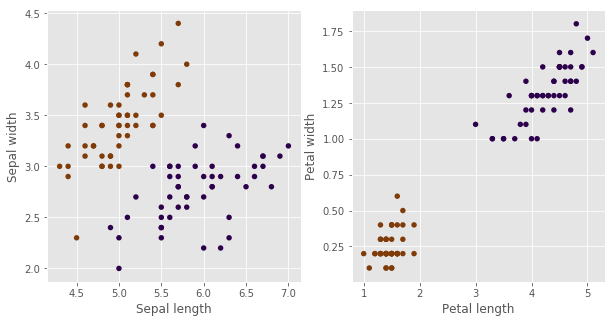

In [4]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [5]:
clusterizer = Clustering()
clusterizer = clusterizer.fit(x_iris)
pred_iris = clusterizer.predict(x_iris)
print ("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


In [6]:
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

GMM score 1.0. GMM time 0.013992071151733398. AGGL score 1.0. AGGL time 0.11493253707885742


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [7]:
# Место для Вашего кластерного анализа

In [171]:
df = pd.read_csv('WDIdata.csv')

In [172]:
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN,NaN
3,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN,NaN
4,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN,NaN


In [173]:
def countries(df, fix_year):
    data = df.loc[:, ['Country Name', 'Indicator Name', fix_year]]
    data = data.pivot(index='Country Name', columns='Indicator Name', values=fix_year)
    data = data.iloc[:, np.array(data.count(axis=0)) >= data.shape[0]-2]
    data = data.fillna(data.mean(), axis=0)
    return data

In [174]:
df[(df['Country Name'] == 'Ukraine') & (df['Indicator Name'] == 'Population, total')]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
401147,Ukraine,UKR,"Population, total",SP.POP.TOTL,42662149.0,43203635.0,43749470.0,44285899.0,44794327.0,45261935.0,...,46053300.0,45870700.0,45706100.0,45593300.0,45489600.0,45271947.0,45154029.0,45004645.0,44831159.0,NaN


In [175]:
df[(df['Country Name'] == 'Ukraine') & (df['Indicator Name'] == 'Land area (sq. km)')]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
400763,Ukraine,UKR,Land area (sq. km),AG.LND.TOTL.K2,NaN,579350.0,579350.0,579350.0,579350.0,579350.0,...,579320.0,579320.0,579320.0,579320.0,579320.0,579290.0,579286.0,579290.0,579290.0,NaN


In [176]:
df = countries(df, '2008')
df.head(50)

Indicator Name,Agricultural methane emissions (thousand metric tons of CO2 equivalent),Agricultural nitrous oxide emissions (thousand metric tons of CO2 equivalent),Land area (sq. km),Methane emissions in energy sector (thousand metric tons of CO2 equivalent),Nitrous oxide emissions in energy sector (thousand metric tons of CO2 equivalent),Population density (people per sq. km of land area),Population growth (annual %),"Population, total",Renewable electricity output (% of total electricity output),Surface area (sq. km)
Country Name,,,,,,,,,,
Afghanistan,7032.248544,2491.781085,652860.0,919.687290,209.336280,41.806867,2.512574,2.729403e+07,68.654822,652860.0
Albania,1635.964817,893.956291,27400.0,649.121126,68.258308,107.566204,-0.767343,2.947314e+06,100.000000,28750.0
Algeria,4755.330185,3040.138321,2381740.0,37642.557772,407.538198,14.636658,1.621298,3.486072e+07,0.703350,2381740.0
American Samoa,2.984883,23.030594,200.0,0.000454,0.000089,285.150000,-1.519175,5.703000e+04,0.000000,200.0
Andorra,0.000000,0.000000,470.0,0.000000,0.000000,178.427660,1.414665,8.386100e+04,80.050826,470.0
Angola,3982.498187,2670.258625,1246700.0,11033.099109,196.816219,17.453614,3.563448,2.175942e+07,75.409047,1246700.0
Antigua and Barbuda,25.385484,12.518428,440.0,1.152972,3.068388,210.177273,1.193320,9.247800e+04,0.000000,440.0
Arab World,150808.645449,129368.098504,13623921.0,250773.283201,6642.780239,24.943295,2.463921,3.398255e+08,3.362739,13781821.0
Argentina,71924.389568,49035.055380,2736690.0,17288.597895,1689.884022,14.755924,1.025900,4.038239e+07,26.343706,2780400.0


In [178]:
scaler = StandardScaler()
scaler.fit(df)
scaled = scaler.transform(df)

In [177]:
scaled

array([[-0.29763515,  1.11030265, -0.28165601, -0.29760649],
       [-0.33955942, -1.29359788, -0.31593001, -0.33816788],
       [-0.18174913,  0.41006944, -0.27558128, -0.18524525],
       ...,
       [-0.30600647,  1.01320821, -0.28929621, -0.30572319],
       [-0.29156697,  1.57040379, -0.30100503, -0.29112366],
       [-0.31546567,  0.95400625, -0.3015972 , -0.31464057]])

Вначале бил на 4 кластера, но данные были довольно неинтерпетируемы. Решено было попробовать 3 кластера

In [179]:
n_clusters = 3
steps = 20

my_model = Clustering(n_clusters, steps)
my_model.fit(scaled)
prediction = my_model.predict(scaled)

In [180]:
for clust in range(n_clusters):
    print("Cluster #{}:".format(clust+1))
    print(df.index.values[prediction == clust])

Cluster #1:
['Algeria' 'Arab World' 'Argentina' 'Australia' 'Brazil' 'Cambodia'
 'Cameroon' 'Caribbean small states' 'Central African Republic'
 'Central Europe and the Baltics' 'Chad' 'Colombia' 'Congo, Dem. Rep.'
 'Czech Republic' 'Egypt, Arab Rep.' 'Ethiopia' 'Finland'
 'Fragile and conflict affected situations' 'France' 'Germany' 'Ghana'
 'Guinea' 'Heavily indebted poor countries (HIPC)' 'IDA blend' 'IDA only'
 'IDA total' 'Indonesia' 'Iran, Islamic Rep.' 'Italy' 'Japan' 'Kazakhstan'
 'Korea, Rep.' 'Least developed countries: UN classification' 'Libya'
 'Low income' 'Malawi' 'Malaysia' 'Mali' 'Mexico'
 'Middle East & North Africa'
 'Middle East & North Africa (IDA & IBRD countries)'
 'Middle East & North Africa (excluding high income)' 'Mongolia' 'Myanmar'
 'Nepal' 'New Zealand' 'Nigeria' 'Norway' 'Not classified'
 'Other small states' 'Pakistan' 'Philippines' 'Poland'
 'Pre-demographic dividend' 'Qatar' 'Saudi Arabia' 'Small states'
 'South Africa' 'South Sudan' 'Spain' 'Sub-Sahar

In [181]:
df = pd.read_csv('WDIdata.csv')
df = countries(df, '2017')
df.head(50)

Indicator Name,Land area (sq. km),Population growth (annual %),"Population, total",Surface area (sq. km)
Country Name,,,,
Afghanistan,652860.0,2.490790,3.553008e+07,652860.0
Albania,27400.0,-0.091972,2.873457e+06,28750.0
Algeria,2381741.0,1.738456,4.131814e+07,2381740.0
American Samoa,200.0,0.075512,5.564100e+04,200.0
Andorra,470.0,-0.409736,7.696500e+04,470.0
Angola,1246700.0,3.313507,2.978419e+07,1246700.0
Antigua and Barbuda,440.0,1.033634,1.020120e+05,440.0
Arab World,13621413.0,1.977892,4.144919e+08,13152649.5
Argentina,2736690.0,0.961465,4.427104e+07,2780400.0


In [183]:
scaler = StandardScaler()
scaler.fit(df)
scaled = scaler.transform(df)

In [184]:
my_model = Clustering(n_clusters, steps)
my_model.fit(scaled)
prediction = my_model.predict(scaled)

In [185]:
for clust in range(n_clusters):
    print("Cluster #{}:".format(clust+1))
    print(df.index.values[prediction == clust])

Cluster #1:
['Arab World' 'Australia' 'Brazil' 'Canada' 'China'
 'Early-demographic dividend' 'East Asia & Pacific'
 'East Asia & Pacific (IDA & IBRD countries)'
 'East Asia & Pacific (excluding high income)' 'Eritrea' 'Ethiopia'
 'Euro area' 'Europe & Central Asia'
 'Europe & Central Asia (IDA & IBRD countries)'
 'Europe & Central Asia (excluding high income)' 'European Union'
 'Fragile and conflict affected situations'
 'Heavily indebted poor countries (HIPC)' 'High income' 'IBRD only'
 'IDA & IBRD total' 'IDA blend' 'IDA only' 'IDA total' 'India' 'Indonesia'
 'Iran, Islamic Rep.' 'Late-demographic dividend'
 'Latin America & Caribbean'
 'Latin America & Caribbean (excluding high income)'
 'Latin America & the Caribbean (IDA & IBRD countries)'
 'Least developed countries: UN classification' 'Low & middle income'
 'Low income' 'Lower middle income' 'Middle East & North Africa'
 'Middle East & North Africa (IDA & IBRD countries)'
 'Middle East & North Africa (excluding high income)' 'M

In [186]:
df[prediction == 0].head()

Indicator Name,Land area (sq. km),Population growth (annual %),"Population, total",Surface area (sq. km)
Country Name,,,,
Arab World,13621413.0,1.977892,4.144919e+08,13152649.5
Australia,7682300.0,1.590388,2.459893e+07,7741220.0
Brazil,8358140.0,0.784485,2.092883e+08,8515770.0
Canada,9093510.0,1.215481,3.670808e+07,9984670.0
China,9388211.0,0.559121,1.386395e+09,9562911.0


In [187]:
df[prediction == 1].head()

Indicator Name,Land area (sq. km),Population growth (annual %),"Population, total",Surface area (sq. km)
Country Name,,,,
Albania,27400.0,-0.091972,2873457.0,28750.0
American Samoa,200.0,0.075512,55641.0,200.0
Andorra,470.0,-0.409736,76965.0,470.0
Antigua and Barbuda,440.0,1.033634,102012.0,440.0
Armenia,28470.0,0.192442,2930450.0,29740.0


In [188]:
df[prediction == 2].head()

Indicator Name,Land area (sq. km),Population growth (annual %),"Population, total",Surface area (sq. km)
Country Name,,,,
Afghanistan,652860.0,2.490790,35530081.0,652860.0
Algeria,2381741.0,1.738456,41318142.0,2381740.0
Angola,1246700.0,3.313507,29784193.0,1246700.0
Argentina,2736690.0,0.961465,44271041.0,2780400.0
Azerbaijan,82663.0,1.066429,9862429.0,86600.0


Кластер 1 - страны с большим населением и площадью

Кластер 2 - малое население/площадь

Кластер 3 - средняя площадь выше среднего население

Как пример, Украина перетекла из 1 кластера в 3, видимо, в силу политичеких событий

In [189]:
# Не переживайте, мне тоже было тяжело разобраться с данными

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***
Мы можем группировать какие-либо предложения для клиента в зависимости от его интересов, возможно есть ситуации, когда удобнее работать с набором обхектов, а не с каждым по отдеельности, тогда кластеризовав мы упрощае задачу

==================

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***

K-means:

Плюсы:
* Простой в реализации
* Дешевый в плане производительности
* Центроиды могут помочь интерпретировать кластеры

Минусы:
* Кластеры получаются сферической формы
* В классическом варианте требуется задание числа кластеров, результат сильно зависит от начальной инициализации

Dbscan:

Плюсы:
* Автоматически определяет число кластеров
* Выделяет кластеры любой формы

Минусы:
* Плохо работает, если у кластеров разная плотность

Агломеративная кластеризация:

Плюсы:
* Выделяет кластеры любой формы
* Позволяет получить дендрограмму, из которой можно достать некоторую полезную информацию

Минусы:
* Требует много ресурсов

===============================

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***

Если правдоподобие неограничено


* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись?

***Ваше ответ здесь***

Да, необходимо использовать:  PCA, t-SNE, отбор признаков.

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***

Word2Vec + кластеризация

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***

Что-нибудь в духе TfIdf + деревья ? Если честно, не знаю

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***